In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.signal import argrelextrema
from collections import deque
from matplotlib.lines import Line2D # For legend

https://raposa.trade/blog/test-and-trade-rsi-divergence-in-python/

In [8]:
def getHigherLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be higher.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] < lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be lower.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] > highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getHigherHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be higher.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=5)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] < highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be lower.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] > lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

In [9]:
start = '2011-01-01'
end = '2011-07-31'
ticker = 'XOM'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start=start, end=end)
# Drop unused columns
data.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 
  'Stock Splits'], axis=1, inplace=True)

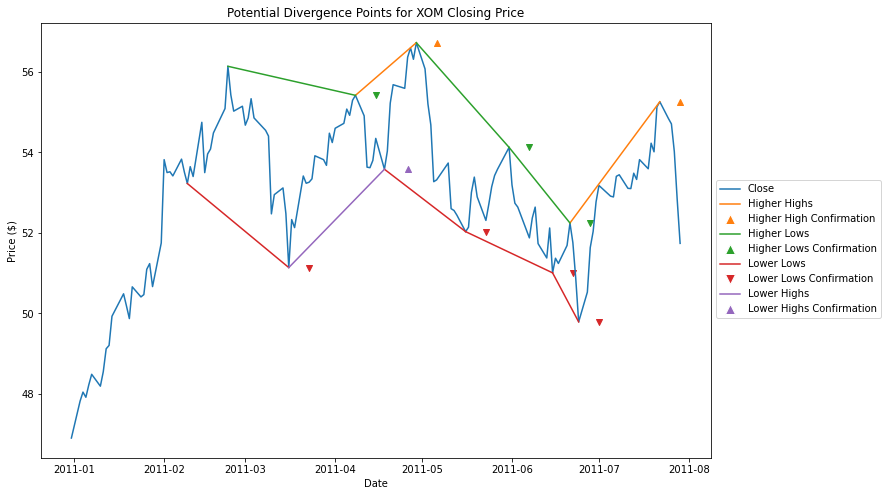

In [10]:
price = data['Close'].values
dates = data.index
# Get higher highs, lower lows, etc.
order = 5
hh = getHigherHighs(price, order)
lh = getLowerHighs(price, order)
ll = getLowerLows(price, order)
hl = getHigherLows(price, order)
# Get confirmation indices
hh_idx = np.array([i[1] + order for i in hh])
lh_idx = np.array([i[1] + order for i in lh])
ll_idx = np.array([i[1] + order for i in ll])
hl_idx = np.array([i[1] + order for i in hl])
# Plot results
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(12, 8))
plt.plot(data['Close'])
plt.scatter(dates[hh_idx], price[hh_idx-order], marker='^', c=colors[1])
plt.scatter(dates[lh_idx], price[lh_idx-order], marker='v', c=colors[2])
plt.scatter(dates[ll_idx], price[ll_idx-order], marker='v', c=colors[3])
plt.scatter(dates[hl_idx], price[hl_idx-order], marker='^', c=colors[4])
_ = [plt.plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [plt.plot(dates[i], price[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], price[i], c=colors[4]) for i in hl]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.65))
plt.show()

In [11]:
def calcRSI(data, P=14):
  data['diff_close'] = data['Close'] - data['Close'].shift(1)
  data['gain'] = np.where(data['diff_close']>0, data['diff_close'], 0)
  data['loss'] = np.where(data['diff_close']<0, np.abs(data['diff_close']), 0)
  data[['init_avg_gain', 'init_avg_loss']] = data[
    ['gain', 'loss']].rolling(P).mean()
  avg_gain = np.zeros(len(data))
  avg_loss = np.zeros(len(data))
  for i, _row in enumerate(data.iterrows()):
    row = _row[1]
    if i < P - 1:
      last_row = row.copy()
      continue
    elif i == P-1:
      avg_gain[i] += row['init_avg_gain']
      avg_loss[i] += row['init_avg_loss']
    else:
      avg_gain[i] += ((P - 1) * avg_gain[i-1] + row['gain']) / P
      avg_loss[i] += ((P - 1) * avg_loss[i-1] + row['loss']) / P
          
    last_row = row.copy()
      
  data['avg_gain'] = avg_gain
  data['avg_loss'] = avg_loss
  data['RS'] = data['avg_gain'] / data['avg_loss']
  data['RSI'] = 100 - 100 / (1 + data['RS'])
  return data

In [12]:
data = calcRSI(data.copy())
rsi = data['RSI'].values
# Get values to mark RSI highs/lows and plot
rsi_hh = getHigherHighs(rsi, order)
rsi_lh = getLowerHighs(rsi, order)
rsi_ll = getLowerLows(rsi, order)
rsi_hl = getHigherLows(rsi, order)

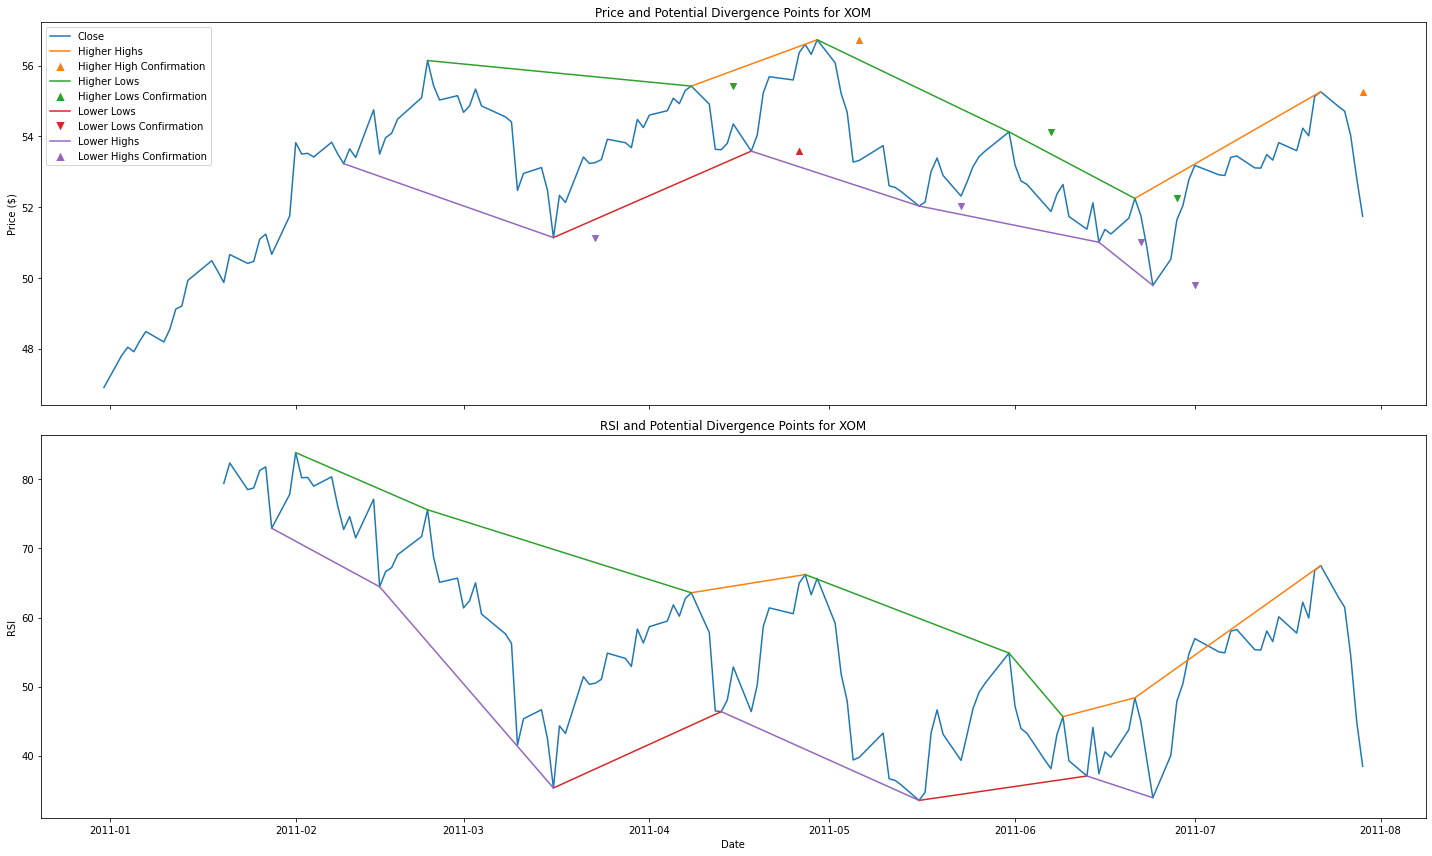

In [13]:
fig, ax = plt.subplots(2, figsize=(20, 12), sharex=True)
ax[0].plot(data['Close'])
ax[0].scatter(dates[hh_idx], price[hh_idx-order], 
              marker='^', c=colors[1])
ax[0].scatter(dates[lh_idx], price[lh_idx-order],
              marker='v', c=colors[2])
ax[0].scatter(dates[hl_idx], price[hl_idx-order],
              marker='^', c=colors[3])
ax[0].scatter(dates[ll_idx], price[ll_idx-order],
              marker='v', c=colors[4])
_ = [ax[0].plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [ax[0].plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [ax[0].plot(dates[i], price[i], c=colors[3]) for i in hl]
_ = [ax[0].plot(dates[i], price[i], c=colors[4]) for i in ll]
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'Price and Potential Divergence Points for {ticker}')
ax[0].legend(handles=legend_elements)
ax[1].plot(data['RSI'])
# Get confirmation indices
# rsi_hh_idx = np.array([i[1] for i in rsi_hh])
# rsi_lh_idx = np.array([i[1] for i in rsi_lh])
# rsi_ll_idx = np.array([i[1] for i in rsi_ll])
# rsi_hl_idx = np.array([i[1] for i in rsi_hl])

# ax[1].scatter(dates[rsi_hh_idx], rsi[rsi_hh_idx-order], 
#               marker='^', c=colors[1])
# ax[1].scatter(dates[rsi_lh_idx], rsi[rsi_lh_idx-order],
#               marker='v', c=colors[2])
# ax[1].scatter(dates[rsi_hl_idx], rsi[rsi_hl_idx-order],
#               marker='^', c=colors[3])
# ax[1].scatter(dates[rsi_ll_idx], rsi[rsi_ll_idx-order],
#               marker='v', c=colors[4])

_ = [ax[1].plot(dates[i], rsi[i], c=colors[1]) for i in rsi_hh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[2]) for i in rsi_lh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[3]) for i in rsi_hl]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[4]) for i in rsi_ll]
ax[1].set_ylabel('RSI')
ax[1].set_title(f'RSI and Potential Divergence Points for {ticker}')
ax[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [14]:
def getHHIndex(data: np.array, order=5, K=2):
  extrema = getHigherHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLHIndex(data: np.array, order=5, K=2):
  extrema = getLowerHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLLIndex(data: np.array, order=5, K=2):
  extrema = getLowerLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getHLIndex(data: np.array, order=5, K=2):
  extrema = getHigherLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

In [15]:
def getPeaks(data, key='Close', order=5, K=2):
  vals = data[key].values
  hh_idx = getHHIndex(vals, order, K)
  lh_idx = getLHIndex(vals, order, K)
  ll_idx = getLLIndex(vals, order, K)
  hl_idx = getHLIndex(vals, order, K)

  data[f'{key}_highs'] = np.nan
  data[f'{key}_highs'][hh_idx] = 1
  data[f'{key}_highs'][lh_idx] = -1
  data[f'{key}_highs'] = data[f'{key}_highs'].ffill().fillna(0)
  data[f'{key}_lows'] = np.nan
  data[f'{key}_lows'][ll_idx] = 1
  data[f'{key}_lows'][hl_idx] = -1
  data[f'{key}_lows'] = data[f'{key}_highs'].ffill().fillna(0)
  return data

In [16]:
def RSIDivergenceStrategy(data, P=14, order=5, K=2):
  '''
  Go long/short on price and RSI divergence.
  - Long if price to lower low and RSI to higher low with RSI < 50
  - Short if price to higher high and RSI to lower high with RSI > 50
  Sell if divergence disappears.
  Sell if the RSI crosses the centerline.
  '''
  data = getPeaks(data, key='Close', order=order, K=K)
  data = calcRSI(data, P=P)
  data = getPeaks(data, key='RSI', order=order, K=K)

  position = np.zeros(data.shape[0])
  for i, (t, row) in enumerate(data.iterrows()):
    if np.isnan(row['RSI']):
      continue
    # If no position is on
    if position[i-1] == 0:
      # Buy if indicator to higher low and price to lower low
      if row['Close_lows'] == -1 and row['RSI_lows'] == 1:
        if row['RSI'] < 50:
          position[i] = 1
          entry_rsi = row['RSI'].copy()

      # Short if price to higher high and indicator to lower high
      elif row['Close_highs'] == 1 and row['RSI_highs'] == -1:
        if row['RSI'] > 50:
          position[i] = -1
          entry_rsi = row['RSI'].copy()

    # If current position is long
    elif position[i-1] == 1:
      if row['RSI'] < 50 and row['RSI'] < entry_rsi:
        position[i] = 1
  
    # If current position is short
    elif position[i-1] == -1:
      if row['RSI'] < 50 and row['RSI'] > entry_rsi:
        position[i] = -1

  data['position'] = position
  return calcReturns(data)

def calcReturns(df):
  # Helper function to avoid repeating too much code
  df['returns'] = df['Close'] / df['Close'].shift(1)
  df['log_returns'] = np.log(df['returns'])
  df['strat_returns'] = df['position'].shift(1) * df['returns']
  df['strat_log_returns'] = df['position'].shift(1) * df['log_returns']
  df['cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1
  df['strat_cum_returns'] = np.exp(df['strat_log_returns'].cumsum()) - 1
  df['peak'] = df['cum_returns'].cummax()
  df['strat_peak'] = df['strat_cum_returns'].cummax()
  return df

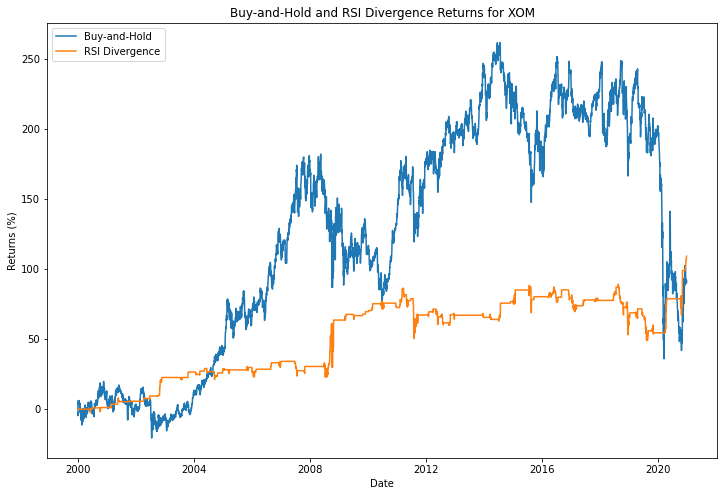

NameError: name 'getStratStats' is not defined

In [17]:
start = '2000-01-01'
end = '2020-12-31'
data = yfObj.history(start=start, end=end)
# Drop unused columns
data.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 
  'Stock Splits'], axis=1, inplace=True)

df_div = RSIDivergenceStrategy(data.copy())

plt.figure(figsize=(12, 8))
plt.plot(df_div['cum_returns'] * 100, label='Buy-and-Hold')
plt.plot(df_div['strat_cum_returns'] * 100, label='RSI Divergence')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.title(f'Buy-and-Hold and RSI Divergence Returns for {ticker}')
plt.legend()
plt.show()
df_stats = pd.DataFrame(getStratStats(df_div['log_returns']), 
                        index=['Buy and Hold'])
df_stats = pd.concat([df_stats, 
                      pd.DataFrame(getStratStats(df_div['strat_log_returns']),
                                   index=['Divergence'])])
df_stats

### Integrate with pandas ta

In [35]:
start = '2011-01-01'
end = '2011-07-31'
ticker = 'XOM'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start=start, end=end)
# Drop unused columns
data.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 
  'Stock Splits'], axis=1, inplace=True)

In [36]:
import pandas_ta as ta

In [37]:
df = data.copy()
df['RSI'] = ta.rsi(df['Close'], length = 14)
df

,Close,RSI
Date,,
2010-12-31,46.899624,NaN
2011-01-03,47.816833,NaN
2011-01-04,48.041321,NaN
2011-01-05,47.913040,NaN
2011-01-06,48.220921,NaN
...,...,...
2011-07-25,54.838840,62.877653
2011-07-26,54.709171,61.476915
2011-07-27,54.021812,54.540837


In [28]:
order = 5
price = df['Close'].values
dates = df.index
rsi = df['RSI'].values

# Get values to mark RSI highs/lows and plot
rsi_hh = getHigherHighs(rsi, order)
rsi_lh = getLowerHighs(rsi, order)
rsi_ll = getLowerLows(rsi, order)
rsi_hl = getHigherLows(rsi, order)

rsi_hh_idx = np.array([i[1] + order for i in rsi_hh])
rsi_lh_idx = np.array([i[1] + order for i in rsi_lh])
rsi_ll_idx = np.array([i[1] + order for i in rsi_ll])
rsi_hl_idx = np.array([i[1] + order for i in rsi_hl])

In [29]:
rsi_hh[0]

deque([68, 80])

In [30]:
hh = getHigherHighs(price, order)
lh = getLowerHighs(price, order)
ll = getLowerLows(price, order)
hl = getHigherLows(price, order)

# Get confirmation indices
hh_idx = np.array([i[1] + order for i in hh])
lh_idx = np.array([i[1] + order for i in lh])
ll_idx = np.array([i[1] + order for i in ll])
hl_idx = np.array([i[1] + order for i in hl])

In [31]:
for i in hh:
    print(i)

deque([68, 82], maxlen=2)
deque([118, 140], maxlen=2)


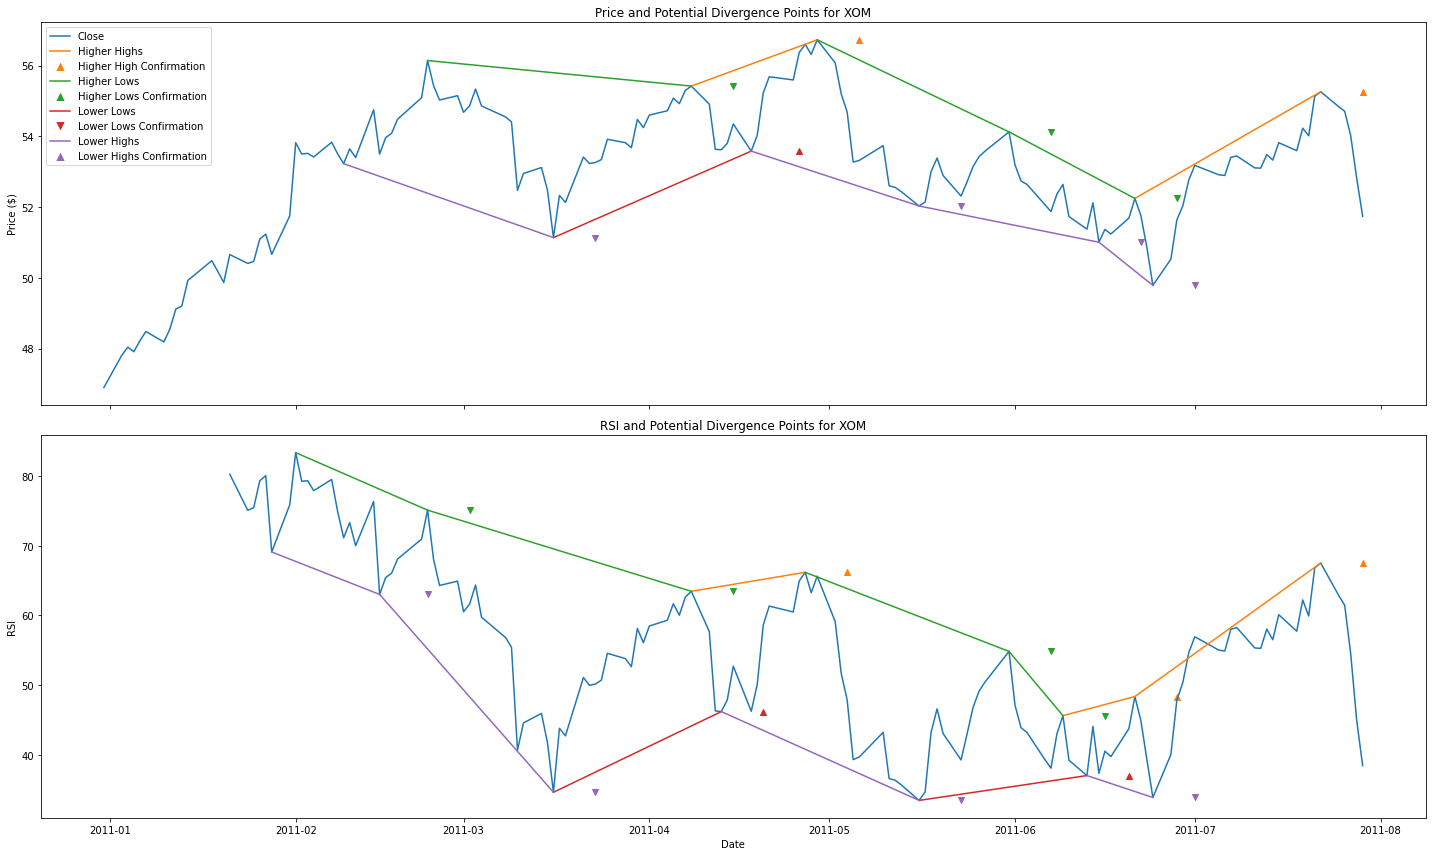

In [32]:
fig, ax = plt.subplots(2, figsize=(20, 12), sharex=True)
ax[0].plot(df['Close'])

ax[0].scatter(dates[hh_idx], price[hh_idx-order], 
              marker='^', c=colors[1])
ax[0].scatter(dates[lh_idx], price[lh_idx-order],
              marker='v', c=colors[2])
ax[0].scatter(dates[hl_idx], price[hl_idx-order],
              marker='^', c=colors[3])
ax[0].scatter(dates[ll_idx], price[ll_idx-order],
              marker='v', c=colors[4])

_ = [ax[0].plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [ax[0].plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [ax[0].plot(dates[i], price[i], c=colors[3]) for i in hl]
_ = [ax[0].plot(dates[i], price[i], c=colors[4]) for i in ll]

ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'Price and Potential Divergence Points for {ticker}')
ax[0].legend(handles=legend_elements)

ax[1].plot(df['RSI'])
ax[1].scatter(dates[rsi_hh_idx], rsi[rsi_hh_idx-order], 
              marker='^', c=colors[1])
ax[1].scatter(dates[rsi_lh_idx], rsi[rsi_lh_idx-order],
              marker='v', c=colors[2])
ax[1].scatter(dates[rsi_hl_idx], rsi[rsi_hl_idx-order],
              marker='^', c=colors[3])
ax[1].scatter(dates[rsi_ll_idx], rsi[rsi_ll_idx-order],
              marker='v', c=colors[4])

_ = [ax[1].plot(dates[i], rsi[i], c=colors[1]) for i in rsi_hh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[2]) for i in rsi_lh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[3]) for i in rsi_hl]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[4]) for i in rsi_ll]
ax[1].set_ylabel('RSI')
ax[1].set_title(f'RSI and Potential Divergence Points for {ticker}')
ax[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [38]:
peaks_close = getPeaks(df, key='Close', order=5, K=2)
peaks_rsi = getPeaks(df, key='RSI', order=5, K=2)

In [39]:
peaks_close

,Close,RSI,Close_highs,Close_lows,RSI_highs,RSI_lows
Date,,,,,,
2010-12-31,46.899624,NaN,0.0,0.0,0.0,0.0
2011-01-03,47.816833,NaN,0.0,0.0,0.0,0.0
2011-01-04,48.041321,NaN,0.0,0.0,0.0,0.0
2011-01-05,47.913040,NaN,0.0,0.0,0.0,0.0
2011-01-06,48.220921,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2011-07-25,54.838840,62.877653,-1.0,-1.0,1.0,1.0
2011-07-26,54.709171,61.476915,-1.0,-1.0,1.0,1.0
2011-07-27,54.021812,54.540837,-1.0,-1.0,1.0,1.0


In [40]:
peaks_rsi

,Close,RSI,Close_highs,Close_lows,RSI_highs,RSI_lows
Date,,,,,,
2010-12-31,46.899624,NaN,0.0,0.0,0.0,0.0
2011-01-03,47.816833,NaN,0.0,0.0,0.0,0.0
2011-01-04,48.041321,NaN,0.0,0.0,0.0,0.0
2011-01-05,47.913040,NaN,0.0,0.0,0.0,0.0
2011-01-06,48.220921,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2011-07-25,54.838840,62.877653,-1.0,-1.0,1.0,1.0
2011-07-26,54.709171,61.476915,-1.0,-1.0,1.0,1.0
2011-07-27,54.021812,54.540837,-1.0,-1.0,1.0,1.0


In [131]:
position = np.zeros(df.shape[0])
for i, (t, row) in enumerate(df.iterrows()):
    # i = index, t = datetime, row = row
    if np.isnan(row['RSI']):
      continue
    # If no position is on
    if position[i-1] == 0:
      # Buy if indicator to higher low and price to lower low
      if row['Close_lows'] == -1 and row['RSI_lows'] == 1:
        if row['RSI'] < 50:
          position[i] = 1
          entry_rsi = row['RSI'].copy()

      # Short if price to higher high and indicator to lower high
      elif row['Close_highs'] == 1 and row['RSI_highs'] == -1:
        if row['RSI'] > 50:
          position[i] = -1
          entry_rsi = row['RSI'].copy()

    # If current position is long
    elif position[i-1] == 1:
      if row['RSI'] < 50 and row['RSI'] < entry_rsi:
        position[i] = 1
  
    # If current position is short
    elif position[i-1] == -1:
      if row['RSI'] < 50 and row['RSI'] > entry_rsi:
        position[i] = -1

In [132]:
position

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])